In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
idx = pd.IndexSlice

In [2]:
with open('data/usage', 'rb') as file:
    usage = pickle.load(file)
usage

,N,Usage
Extra Soft,4,0.012161
Soft,3,0.010271
Medium,3,0.006243
Hard,2,0.005913
Rain,4,0.005172
Fuel,16.0,0.003912


In [3]:
tracks = pd.read_pickle('data/96/tracks')
tracks.index += 1
tracks['Lap distance'] = pd.to_numeric(tracks['Lap distance'].str.split().str[0])
tracks

,Track name,Country,Kms,Laps,Lap distance,Power,Handling,Acceleration,Category,GPs held
1,Interlagos,Brazil,305.9,71,4.308,NaN,NaN,NaN,F1,33
2,Melbourne,Australia,307.6,58,5.303,NaN,NaN,NaN,F1,33
3,Mexico City,Mexico,305.0,69,4.420,NaN,NaN,NaN,F1,41
4,Buenos Aires,Argentina,306.6,72,4.258,NaN,NaN,NaN,ex F1,35
5,Las Vegas,United States,305.9,50,6.118,NaN,NaN,NaN,F1,1
6,Fuji,Japan,305.4,67,4.558,NaN,NaN,NaN,ex F1,36
7,Yas Marina,United Arab Emirates,305.5,55,5.555,NaN,NaN,NaN,F1,39
8,Shanghai,China,305.2,56,5.450,NaN,NaN,NaN,F1,36
9,Istanbul,Turkey,309.4,58,5.334,NaN,NaN,NaN,ex F1,36
10,Sepang,Malaysia,310.4,55,5.644,NaN,NaN,NaN,ex F1,39


In [4]:
practice = pd.read_pickle('data/quali_practice')
pitstime = pd.read_pickle('data/pitstime')

Convert net time to seconds

In [5]:
from datetime import datetime, timedelta

In [6]:
def to_timedelta(str, format = '%M:%S.%fs'):
    if str == '-':
        return pd.NA
    parsed_time = datetime.strptime(str, format)
    return timedelta(
        minutes=parsed_time.minute,
        seconds=parsed_time.second,
        microseconds=parsed_time.microsecond
    )

In [7]:
practice['Net time'] = practice['Net time'].apply(lambda t: to_timedelta(t).total_seconds())
practice

1,Lap,Lap time,Driver mistake,Net time,FWing,RWing,Engine,Brakes,Gear,Susp,Tyres,Comm
2,1,1:37.831s,1.395s,96.436,650,650,500,500,350,350,Extra Soft,NaN
3,2,1:37.916s,1.131s,96.785,650,650,450,500,350,350,Soft,NaN
4,3,1:38.434s,1.287s,97.147,650,650,450,500,350,350,Medium,NaN
5,4,1:39.389s,1.770s,97.619,600,600,425,500,325,400,Hard,NaN
6,5,1:37.757s,1.311s,96.446,650,650,425,500,325,400,Extra Soft,NaN
7,6,1:38.074s,1.225s,96.849,650,650,425,500,325,475,Soft,NaN
8,7,1:38.375s,1.205s,97.170,650,650,425,500,325,400,Medium,NaN
9,8,1:39.365s,1.856s,97.509,650,650,450,500,350,350,Hard,NaN


Calculate strategy times per tyre

In [8]:
def get_strategies(track, tol, tyres = ['Extra Soft', 'Soft', 'Medium', 'Hard', 'Rain']):
    strategies = pd.DataFrame([], tyres, ['Stints', 'Stops', 'Time', 'Laps'])
    strategies['Laps'] = (1-tol) / (usage['Usage']*tracks.loc[track, 'Lap distance'])
    strategies['Stints'] = tracks.loc[track, 'Laps'] / np.floor(strategies['Laps'])
    strategies['Stops'] = np.ceil(strategies['Stints']) - 1 # np.ceil(x) - 1 != np.floor(x) e.g. x = 1
    strategies['Time'] = practice.groupby('Tyres')['Net time'].min() * tracks.loc[track, 'Laps']+ pitstime.loc['No more fuel was left', 'Average'] * strategies['Stops']
    strategies['Fuel'] = usage.loc['Fuel', 'Usage'] * strategies['Laps'] * tracks.loc[track, 'Lap distance']
    return strategies

In [9]:
get_strategies(15, 0.27)

,Stints,Stops,Time,Laps,Fuel
Extra Soft,5.5,5,6489.924182,12.793966,0.234845
Soft,4.4,4,6487.928545,15.148215,0.278059
Medium,2.75,2,6461.761273,24.920952,0.457447
Hard,2.538462,2,6485.653273,26.309991,0.482944
Rain,2.2,2,NaN,30.082502,0.552192


Text(0, 0.5, 'Total racetime')

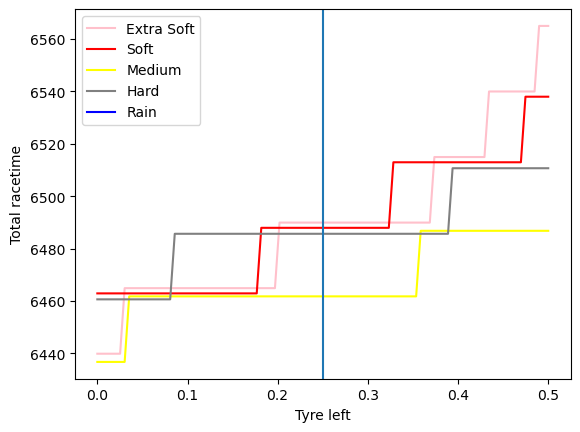

In [10]:
col = {'Extra Soft': 'pink', 'Soft': 'red', 'Medium': 'yellow', 'Hard': 'grey', 'Rain': 'blue'}
grid = np.linspace(0, 0.5, 100)
times = pd.DataFrame([get_strategies(15, x)['Time'] for x in grid])
for tyre in times:
    plt.plot(grid, times[tyre], c = col[tyre], label = tyre)
plt.axvline(0.25)
plt.legend()
plt.xlabel('Tyre left')
plt.ylabel('Total racetime')

In [11]:
get_strategies(15, .35)

,Stints,Stops,Time,Laps,Fuel
Extra Soft,6.0,5,6489.924182,11.391888,0.209108
Soft,5.076923,5,6512.958182,13.488137,0.247587
Medium,3.0,2,6461.761273,22.189889,0.407316
Hard,2.869565,2,6485.653273,23.426704,0.430019
Rain,2.538462,2,NaN,26.78579,0.491678
